In [2]:
!pip install nltk emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 29.4 MB/s eta 0:00:00


In [3]:
import emoji
import string
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support
)

In [4]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
class TextPreProcessor:
    def __init__(self, custom_stopwords = None):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        if custom_stopwords:
            self.stop_words.update(custom_stopwords)

    def _get_wordnet_pos(self, word):
        tag = pos_tag([word])[0][1][0].upper()
        tag_dict = {
            'J': wordnet.ADJ,
            'N': wordnet.NOUN,
            'V': wordnet.VERB,
            'R': wordnet.ADV
        }
        return tag_dict.get(tag, wordnet.NOUN)

    def preprocess(self, text):
        if not isinstance(text, str):
            return ""

        text = text.lower()
        text = emoji.demojize(text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(text)
        filtered_tokens = []
        for token in tokens:
            if token not in self.stop_words and token.isalpha():
                pos = self._get_wordnet_pos(token)
                lemma = self.lemmatizer.lemmatize(token, pos)
                filtered_tokens.append(lemma)

        return ' '.join(filtered_tokens)

    def preprocess_df(self, df, text_column):
        df_copy = df.copy()
        output_column = 'clean_text'
        df_copy[output_column] = df_copy[text_column].apply(self.preprocess)
        return df_copy

In [ ]:
preproc = TextPreProcessor()

df = pd.read_csv("raw/borderlands.csv")
df_cleaned = preproc.preprocess_df(df, text_column='text')
df_cleaned.to_csv("final/borderlands.csv", index=False)

df = pd.read_csv("raw/airlines.csv")
df_cleaned = preproc.preprocess_df(df, text_column='text')
df_cleaned.to_csv("final/airlines.csv", index=False)

df = pd.read_csv("raw/climate.csv")
df_cleaned = preproc.preprocess_df(df, text_column='text')
df_cleaned.to_csv("final/climate.csv", index=False)

df = pd.read_csv("raw/corona.csv")
df_cleaned = preproc.preprocess_df(df, text_column='text')
df_cleaned.to_csv("final/corona.csv", index=False)

df = pd.read_csv("raw/combined.csv")
df_cleaned = preproc.preprocess_df(df, text_column='text')
df_cleaned.to_csv("final/combined.csv", index=False)

In [6]:
# EDA for airlines
airlines_df = pd.read_csv("final/airlines.csv")

print("First 5 rows of the dataframe:")
display(airlines_df.head())

print("\nInfo about the dataframe:")
airlines_df.info()

print("\nDescription of the dataframe:")
display(airlines_df.describe())

print("\nMissing values per column:")
print(airlines_df.isnull().sum())

print("\nSentiment distribution:")
display(airlines_df['sentiment'].value_counts())

plt.figure(figsize=(4, 4))
sns.countplot(x='sentiment', data=airlines_df)
plt.title('Distribution of Sentiments in Airlines Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Add this check and save plot
output_dir = Path("img")
if output_dir:
    output_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_dir / 'airlines_sentiment_distribution.png', dpi=150)
else:
    plt.show()

plt.close()

# Generate word clouds for positive and negative sentiments
from wordcloud import WordCloud

positive_text = " ".join(airlines_df[airlines_df['sentiment'] == 'positive']['clean_text'])
negative_text = " ".join(airlines_df[airlines_df['sentiment'] == 'negative']['clean_text'])

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiment')
plt.axis('off')

plt.tight_layout()

# Add this check and save plot
output_dir = Path("img")
if output_dir:
    output_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_dir / 'airlines_wordclouds.png', dpi=150)
else:
    plt.show()

plt.close()

First 5 rows of the dataframe:


,sentiment,text,clean_text
0,neutral,@VirginAmerica What @dhepburn said.,virginamerica dhepburn say
1,positive,@VirginAmerica plus you've added commercials t...,virginamerica plus youve add commercial experi...
2,neutral,@VirginAmerica I didn't today... Must mean I n...,virginamerica didnt today must mean need take ...
3,negative,@VirginAmerica it's really aggressive to blast...,virginamerica really aggressive blast obnoxiou...
4,negative,@VirginAmerica and it's a really big bad thing...,virginamerica really big bad thing



Info about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentiment   14640 non-null  object
 1   text        14640 non-null  object
 2   clean_text  14640 non-null  object
dtypes: object(3)
memory usage: 343.3+ KB

Description of the dataframe:


,sentiment,text,clean_text
count,14640,14640,14640
unique,3,14427,14238
top,negative,@united thanks,united thank
freq,9178,6,20



Missing values per column:
sentiment     0
text          0
clean_text    0
dtype: int64

Sentiment distribution:


,count
sentiment,
negative,9178
neutral,3099
positive,2363


In [7]:
# EDA for climate
climate_df = pd.read_csv("final/climate.csv")

print("First 5 rows of the dataframe:")
display(climate_df.head())

print("\nInfo about the dataframe:")
climate_df.info()

print("\nDescription of the dataframe:")
display(climate_df.describe())

print("\nMissing values per column:")
print(climate_df.isnull().sum())

print("\nSentiment distribution:")
display(climate_df['sentiment'].value_counts())

plt.figure(figsize=(4, 4))
sns.countplot(x='sentiment', data=climate_df)
plt.title('Distribution of Sentiments in Climate Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
# Add this check and save plot
output_dir = Path("img")
if output_dir:
    output_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_dir / 'climate_sentiment_distribution.png', dpi=150)
else:
    plt.show()
plt.close()

# Generate word clouds for positive and negative sentiments
from wordcloud import WordCloud

positive_text = " ".join(climate_df[climate_df['sentiment'] == 'positive']['clean_text'].fillna(''))
negative_text = " ".join(climate_df[climate_df['sentiment'] == 'negative']['clean_text'].fillna(''))

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiment')
plt.axis('off')

plt.tight_layout()
# Add this check and save plot
output_dir = Path("img")
if output_dir:
    output_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_dir / 'climate_wordclouds.png', dpi=150)
else:
    plt.show()
plt.close()

First 5 rows of the dataframe:


,sentiment,text,clean_text
0,negative,@tiniebeany climate change is an interesting h...,tiniebeany climate change interest hustle glob...
1,positive,RT @NatGeoChannel: Watch #BeforeTheFlood right...,rt natgeochannel watch beforetheflood right le...
2,positive,Fabulous! Leonardo #DiCaprio's film on #climat...,fabulous leonardo dicaprios film climate chang...
3,positive,RT @Mick_Fanning: Just watched this amazing do...,rt mickfanning watch amaze documentary leonard...
4,neutral,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",rt cnalive pranita biswasi lutheran odisha giv...



Info about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentiment   43943 non-null  object
 1   text        43943 non-null  object
 2   clean_text  43936 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB

Description of the dataframe:


,sentiment,text,clean_text
count,43943,43943,43936
unique,3,41033,39849
top,positive,RT @StephenSchlegel: she's thinking about how ...,rt stephenschlegel shes think shes go die husb...
freq,22962,506,507



Missing values per column:
sentiment     0
text          0
clean_text    7
dtype: int64

Sentiment distribution:


,count
sentiment,
positive,22962
neutral,16991
negative,3990


In [8]:
# EDA for corona
corona_df = pd.read_csv("final/corona.csv")

print("First 5 rows of the dataframe:")
display(corona_df.head())

print("\nInfo about the dataframe:")
corona_df.info()

print("\nDescription of the dataframe:")
display(corona_df.describe())

print("\nMissing values per column:")
print(corona_df.isnull().sum())

print("\nSentiment distribution:")
display(corona_df['sentiment'].value_counts())

plt.figure(figsize=(4, 4))
sns.countplot(x='sentiment', data=corona_df)
plt.title('Distribution of Sentiments in Corona Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Add this check and save plot
output_dir = Path("img")
if output_dir:
    output_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_dir / 'corona_sentiment_distribution.png', dpi=150)
else:
    plt.show()
plt.close()

# Generate word clouds for positive and negative sentiments
from wordcloud import WordCloud

positive_text = " ".join(corona_df[corona_df['sentiment'] == 'positive']['clean_text'].fillna(''))
negative_text = " ".join(corona_df[corona_df['sentiment'] == 'negative']['clean_text'].fillna(''))

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiment')
plt.axis('off')

plt.tight_layout()
# Add this check and save plot
output_dir = Path("img")
if output_dir:
    output_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_dir / 'corona_wordclouds.png', dpi=150)
else:
    plt.show()
plt.close()

First 5 rows of the dataframe:


,text,sentiment,clean_text
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,neutral,menyrbie philgahan chrisitv
1,advice Talk to your neighbours family to excha...,positive,advice talk neighbour family exchange phone nu...
2,Coronavirus Australia: Woolworths to give elde...,positive,coronavirus australia woolworth give elderly d...
3,My food stock is not the only one which is emp...,positive,food stock one empty please dont panic enough ...
4,"Me, ready to go at supermarket during the #COV...",negative,ready go supermarket outbreak im paranoid food...



Info about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        44955 non-null  object
 1   sentiment   44955 non-null  object
 2   clean_text  44936 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB

Description of the dataframe:


,text,sentiment,clean_text
count,44955,44955,44936
unique,44955,3,44773
top,I and @ForestandPaper members are committed to...,positive,online shopping way restriction
freq,1,19592,6



Missing values per column:
text           0
sentiment      0
clean_text    19
dtype: int64

Sentiment distribution:


,count
sentiment,
positive,19592
negative,17031
neutral,8332


In [10]:
#EDA for borderlands
borderlands_df = pd.read_csv("final/borderlands.csv")

print("First 5 rows of the dataframe:")
display(borderlands_df.head())

print("\nInfo about the dataframe:")
borderlands_df.info()

print("\nDescription of the dataframe:")
display(borderlands_df.describe())

print("\nMissing values per column:")
print(borderlands_df.isnull().sum())

print("\nSentiment distribution:")
display(borderlands_df['sentiment'].value_counts())

plt.figure(figsize=(4, 4))
sns.countplot(x='sentiment', data=borderlands_df)
plt.title('Distribution of Sentiments in Borderlands Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
# Add this check and save plot
output_dir = Path("img")
if output_dir:
    output_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_dir / 'borderlands_sentiment_distribution.png', dpi=150)
else:
    plt.show()
plt.close()

# Generate word clouds for positive and negative sentiments
from wordcloud import WordCloud

positive_text = " ".join(borderlands_df[borderlands_df['sentiment'] == 'positive']['clean_text'].fillna(''))
negative_text = " ".join(borderlands_df[borderlands_df['sentiment'] == 'negative']['clean_text'].fillna(''))

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiment')
plt.axis('off')

plt.tight_layout()
# Add this check and save plot
output_dir = Path("img")
if output_dir:
    output_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_dir / 'borderlands_wordclouds.png', dpi=150)
else:
    plt.show()
plt.close()

First 5 rows of the dataframe:


,sentiment,text,clean_text
0,positive,im getting on borderlands and i will murder yo...,im get borderland murder
1,positive,I am coming to the borders and I will kill you...,come border kill
2,positive,im getting on borderlands and i will kill you ...,im get borderland kill
3,positive,im coming on borderlands and i will murder you...,im come borderland murder
4,positive,im getting on borderlands 2 and i will murder ...,im get borderland murder



Info about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73824 entries, 0 to 73823
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentiment   73824 non-null  object
 1   text        73824 non-null  object
 2   clean_text  72305 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB

Description of the dataframe:


,sentiment,text,clean_text
count,73824,73824,72305
unique,3,69490,61192
top,neutral,It is not the first time that the EU Commissio...,unk
freq,30893,172,174



Missing values per column:
sentiment        0
text             0
clean_text    1519
dtype: int64

Sentiment distribution:


,count
sentiment,
neutral,30893
negative,22312
positive,20619


First 5 rows of the dataframe:


,sentiment,text,clean_text
0,positive,im getting on borderlands and i will murder yo...,im get borderland murder
1,positive,I am coming to the borders and I will kill you...,come border kill
2,positive,im getting on borderlands and i will kill you ...,im get borderland kill
3,positive,im coming on borderlands and i will murder you...,im come borderland murder
4,positive,im getting on borderlands 2 and i will murder ...,im get borderland murder



Info about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177362 entries, 0 to 177361
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   sentiment   177362 non-null  object
 1   text        177362 non-null  object
 2   clean_text  175817 non-null  object
dtypes: object(3)
memory usage: 4.1+ MB

Description of the dataframe:


,sentiment,text,clean_text
count,177362,177362,175817
unique,3,169905,160034
top,positive,RT @StephenSchlegel: she's thinking about how ...,rt stephenschlegel shes think shes go die husb...
freq,65536,506,507



Missing values per column:
sentiment        0
text             0
clean_text    1545
dtype: int64

Sentiment distribution:


,count
sentiment,
positive,65536
neutral,59315
negative,52511


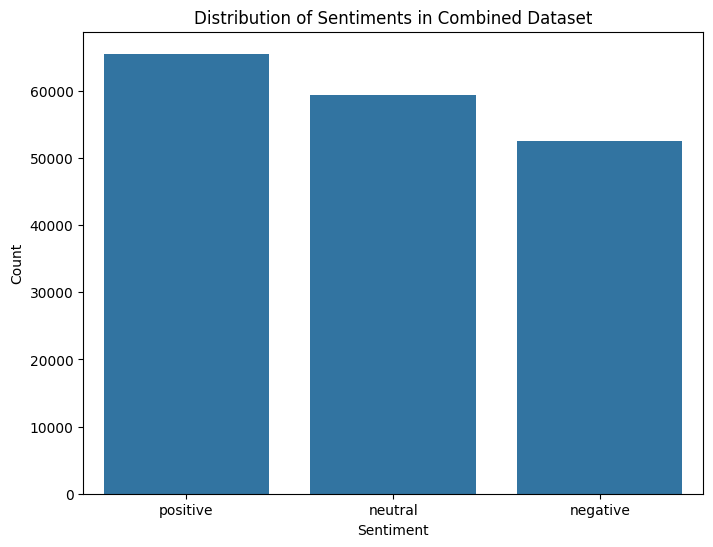

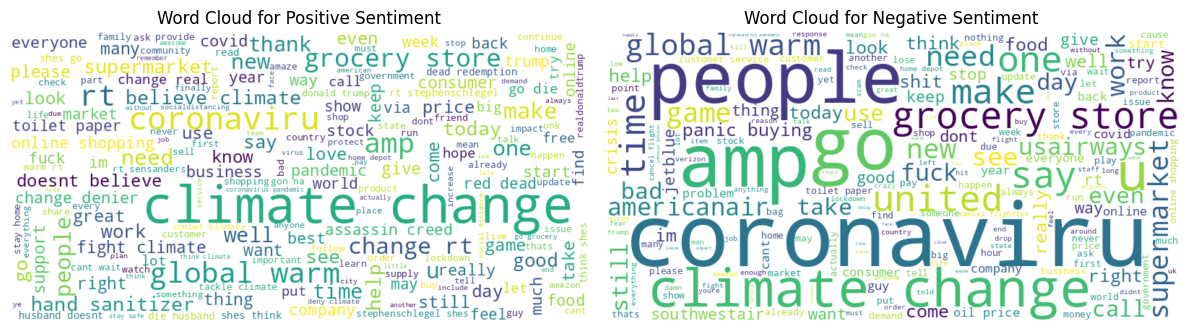

In [ ]:
#EDA for combined
combined_df = pd.read_csv("final/combined.csv")

print("First 5 rows of the dataframe:")
display(combined_df.head())

print("\nInfo about the dataframe:")
combined_df.info()

print("\nDescription of the dataframe:")
display(combined_df.describe())

print("\nMissing values per column:")
print(combined_df.isnull().sum())

print("\nSentiment distribution:")
display(combined_df['sentiment'].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=combined_df)
plt.title('Distribution of Sentiments in Combined Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Generate word clouds for positive and negative sentiments
from wordcloud import WordCloud

positive_text = " ".join(combined_df[combined_df['sentiment'] == 'positive']['clean_text'].fillna(''))
negative_text = " ".join(combined_df[combined_df['sentiment'] == 'negative']['clean_text'].fillna(''))

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiment')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Baseline model
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

class BaselineModel:
    def __init__(self, output_dir=None):
        if output_dir:
            self.output_dir = Path(output_dir)
            self.output_dir.mkdir(parents=True, exist_ok=True)
        else:
            self.output_dir = None

    def _prepare_features_and_target(self, df):
        X = df['clean_text'].fillna('')
        y = df['sentiment']
        return X, y

    def _split_data(self, X, y, test_size = 0.2, random_state = 42):
        return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    def _create_bow_features(self, X_train, X_test, max_features = 5000):
        vectorizer = CountVectorizer(max_features=max_features, stop_words='english')
        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)
        return X_train_vec, X_test_vec, vectorizer

    def _train_logreg(self, X_train_vec, y_train):
        model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
        model.fit(X_train_vec, y_train)
        return model

    def _evaluate(self, model, X_test_vec, y_test):
        y_pred = model.predict(X_test_vec)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average='weighted', zero_division=0
        )

        return {
            'accuracy': accuracy_score(y_test, y_pred),
            'weighted_precision': precision,
            'weighted_recall': recall,
            'weighted_f1': f1,
            'classification_report': classification_report(y_test, y_pred, zero_division=0),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'labels': sorted(y_test.unique())
        }

    def _plot_confusion_matrix(self, results, dataset_name):
        cm = results['confusion_matrix']
        labels = results['labels']

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels)

        plt.title(f'Confusion Matrix: {dataset_name.title()}', fontsize=16)
        plt.ylabel('True Sentiment', fontsize=12)
        plt.xlabel('Predicted Sentiment', fontsize=12)
        plt.tight_layout()

        if self.output_dir:
            save_path = self.output_dir / f'{dataset_name}_basline_confusion_matrix.png'
            plt.savefig(save_path, dpi=150)
        else:
            plt.show()

        plt.close()

    def run(self, df, dataset_name):
        X, y = self._prepare_features_and_target(df)
        X_train, X_test, y_train, y_test = self._split_data(X, y)
        X_train_vec, X_test_vec, vectorizer = self._create_bow_features(X_train, X_test)
        model = self._train_logreg(X_train_vec, y_train)
        results = self._evaluate(model, X_test_vec, y_test)
        self._plot_confusion_matrix(results, dataset_name)
        return {
            'model': model,
            'vectorizer': vectorizer,
            'results': results
        }

In [ ]:
cleaned_files = {
    'borderlands': 'final/borderlands.csv',
    'airlines': 'final/airlines.csv',
    'climate': 'final/climate.csv',
    'corona': 'final/corona.csv',
    'combined': 'final/combined.csv'
}

dataframes = {name: pd.read_csv(path) for name, path in cleaned_files.items()}
collected_results = {}
pipeline = BaselineModel("img")
for name, df in dataframes.items():
    output = pipeline.run(df, dataset_name=name)
    print(output['results']['classification_report'])
    collected_results[name] = output['results']


              precision    recall  f1-score   support

    negative       0.73      0.76      0.74      4462
     neutral       0.78      0.65      0.71      6179
    positive       0.65      0.78      0.71      4124

    accuracy                           0.72     14765
   macro avg       0.72      0.73      0.72     14765
weighted avg       0.73      0.72      0.72     14765

              precision    recall  f1-score   support

    negative       0.90      0.78      0.84      1835
     neutral       0.52      0.69      0.60       620
    positive       0.65      0.70      0.67       473

    accuracy                           0.75      2928
   macro avg       0.69      0.72      0.70      2928
weighted avg       0.78      0.75      0.76      2928

              precision    recall  f1-score   support

    negative       0.44      0.68      0.54       798
     neutral       0.68      0.70      0.69      3398
    positive       0.81      0.71      0.76      4593

    accuracy        

In [ ]:
summary_data = []
for name, results in collected_results.items():
    summary_data.append({
        'Dataset': name.title(),
        'Accuracy': results['accuracy'],
        'Weighted F1-Score': results['weighted_f1'],
        'Weighted Precision': results.get('weighted_precision', 'N/A'),
        'Weighted Recall': results.get('weighted_recall', 'N/A')
    })

    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values(by='Weighted F1-Score', ascending=False)
    summary_df.reset_index(drop=True, inplace=True)

display(summary_df)

,Dataset,Accuracy,Weighted F1-Score,Weighted Precision,Weighted Recall
0,Corona,0.768324,0.772595,0.784138,0.768324
1,Airlines,0.750342,0.759588,0.779129,0.750342
2,Borderlands,0.719133,0.718878,0.726695,0.719133
3,Climate,0.704062,0.709833,0.723523,0.704062
4,Combined,0.664083,0.664226,0.665504,0.664083


In [ ]:
# Trial clustering baseline

class ClusteringModel:
    def __init__(self, output_dir=None, n_clusters=3):
        if output_dir:
            self.output_dir = Path(output_dir)
            self.output_dir.mkdir(parents=True, exist_ok=True)
        else:
            self.output_dir = None
        self.n_clusters = n_clusters

    def _prepare_features(self, df):
        X = df['clean_text'].fillna('')
        return X

    def _create_tfidf_features(self, X, max_features=5000):
        vectorizer = CountVectorizer(max_features=max_features, stop_words='english', max_df=0.95, min_df=2)
        X_vec = vectorizer.fit_transform(X)
        return X_vec, vectorizer

    def _fit_kmeans(self, X_vec):
        model = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10)
        model.fit(X_vec)
        return model

    def _evaluate(self, X_vec, labels):
        if len(np.unique(labels)) > 1:
            score = silhouette_score(X_vec, labels)
        else:
            score = -1
        return {'silhouette_score': score}

    def run(self, df, dataset_name):
        X = self._prepare_features(df)
        X_vec, vectorizer = self._create_tfidf_features(X)
        model = self._fit_kmeans(X_vec)
        results = self._evaluate(X_vec, model.labels_)

        cluster_labels, cluster_counts = np.unique(model.labels_, return_counts=True)
        cluster_data = {'labels': cluster_labels.tolist(), 'counts': cluster_counts.tolist()}

        print(f"Results for {dataset_name.title()}: Silhouette Score = {results['silhouette_score']:.4f}")

        return {
            'model': model,
            'vectorizer': vectorizer,
            'results': results,
            'cluster_data': cluster_data
        }

cleaned_files = {
    'borderlands': 'final/borderlands.csv',
    'airlines': 'final/airlines.csv',
    'climate': 'final/climate.csv',
    'corona': 'final/corona.csv',
    'combined': 'final/combined.csv'
}

dataframes = {name: pd.read_csv(path) for name, path in cleaned_files.items()}
collected_results = {}
pipeline = ClusteringModel()
for name, df in dataframes.items():
    output = pipeline.run(df, dataset_name=name)
    collected_results[name] = output['results']
summary_data = []
for name, results in collected_results.items():
    summary_data.append({
        'Dataset': name.title(),
        'Silhouette score': results['silhouette_score'],
    })

    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values(by='silhouette_score', ascending=False)
    summary_df.reset_index(drop=True, inplace=True)

display(summary_df)


Results for Borderlands: Silhouette Score = 0.1331
Results for Airlines: Silhouette Score = 0.0412
Results for Climate: Silhouette Score = 0.0524
Results for Corona: Silhouette Score = 0.0223


KeyboardInterrupt: 

In [ ]:
# Intermediate model

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
class IntermediateModel:
    def __init__(self, output_dir = None):
        if output_dir:
            self.output_dir = Path(output_dir)
            self.output_dir.mkdir(parents=True, exist_ok=True)
        else:
            self.output_dir = None

    def _prepare_features_and_target(self, df):
        X = df['clean_text'].fillna('')
        y = df['sentiment']
        return X, y

    def _split_data(self, X, y, test_size = 0.2, random_state = 42):
        return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    def _create_tfidf_features(self, X_train, X_test):
        vectorizer = TfidfVectorizer(
            max_features=17000,
            ngram_range=(1, 2),
        )
        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)
        return X_train_vec, X_test_vec, vectorizer

    def _train_model(self, model_name, X_train_vec, y_train):
        if model_name.lower() == 'nb':
            model = MultinomialNB(alpha=1.0)
        elif model_name.lower() == 'svm':
            model = LinearSVC(C=1.0, class_weight='balanced', max_iter=2000, random_state=42)
        else:
            raise ValueError("bruh")

        model.fit(X_train_vec, y_train)
        return model

    def _evaluate_model(self, model, X_test_vec, y_test):
        y_pred = model.predict(X_test_vec)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)
        return {
            'accuracy': accuracy_score(y_test, y_pred),
            'weighted_precision': precision,
            'weighted_recall': recall,
            'weighted_f1': f1,
            'classification_report': classification_report(y_test, y_pred, zero_division=0),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'labels': sorted(y_test.unique())
        }

    def _plot_confusion_matrix(self, results, model_name, dataset_name):
        plt.figure(figsize=(8, 6))
        sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='viridis',
                    xticklabels=results['labels'], yticklabels=results['labels'])
        plt.title(f'Confusion Matrix: {model_name} on {dataset_name.title()}', fontsize=16)
        plt.ylabel('True Sentiment', fontsize=12)
        plt.xlabel('Predicted Sentiment', fontsize=12)
        plt.tight_layout()

        if self.output_dir:
            plot_path = self.output_dir / f'{dataset_name}_{model_name}_cm.png'
            plot_path.parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(plot_path, dpi=150)
        else:
            plt.show()
        plt.close()

    def run(self, df, dataset_name) -> dict:
        X, y = self._prepare_features_and_target(df)
        X_train, X_test, y_train, y_test = self._split_data(X, y)
        X_train_vec, X_test_vec, vectorizer = self._create_tfidf_features(X_train, X_test)

        all_model_results = {}

        for model_name_short, model_name_full in [('nb', 'Naive Bayes'), ('svm', 'SVM')]:
            print(f"\n--- Training {model_name_full} Model ---")
            model = self._train_model(model_name_short, X_train_vec, y_train)
            results = self._evaluate_model(model, X_test_vec, y_test)

            print(f"--- Results for {model_name_full} ---")
            print(results['classification_report'])
            self._plot_confusion_matrix(results, model_name_full, dataset_name)

            all_model_results[model_name_short] = {
                'model': model,
                'vectorizer': vectorizer,
                'results': results
            }

        return all_model_results

In [ ]:
cleaned_files = {
    'borderlands': 'final/borderlands.csv',
    'airlines': 'final/airlines.csv',
    'climate': 'final/climate.csv',
    'corona': 'final/corona.csv',
    'combined': 'final/combined.csv'
}

dataframes = {name: pd.read_csv(path) for name, path in cleaned_files.items()}
collected_results = {}
pipeline = IntermediateModel("img")
for name, df in dataframes.items():
    output = pipeline.run(df, dataset_name=name)
    print(output['nb']['results']['classification_report'])
    print(output['svm']['results']['classification_report'])
    collected_results[name] = output


--- Training Naive Bayes Model ---
--- Results for Naive Bayes ---
              precision    recall  f1-score   support

    negative       0.79      0.73      0.76      4462
     neutral       0.71      0.82      0.76      6179
    positive       0.78      0.67      0.72      4124

    accuracy                           0.75     14765
   macro avg       0.76      0.74      0.75     14765
weighted avg       0.76      0.75      0.75     14765


--- Training SVM Model ---
--- Results for SVM ---
              precision    recall  f1-score   support

    negative       0.85      0.85      0.85      4462
     neutral       0.84      0.84      0.84      6179
    positive       0.82      0.82      0.82      4124

    accuracy                           0.84     14765
   macro avg       0.84      0.84      0.84     14765
weighted avg       0.84      0.84      0.84     14765

              precision    recall  f1-score   support

    negative       0.79      0.73      0.76      4462
     neut

In [ ]:
summary_data = []

for name, output in collected_results.items():
    for key, data in output.items():
        results = data['results']

        summary_data.append({
            'Dataset': name.title(),
            'Model': 'Naive Bayes' if key == 'nb' else 'SVM',
            'Accuracy': results['accuracy'],
            'Weighted F1-Score': results['weighted_f1'],
            'Weighted Precision': results['weighted_precision'],
            'Weighted Recall': results['weighted_recall'],
        })
summary_df = pd.DataFrame(summary_data, columns=['Dataset', 'Model', 'Accuracy', 'Weighted F1-Score', 'Weighted Precision', 'Weighted Recall'])
summary_df = summary_df.sort_values(by=['Dataset', 'Weighted F1-Score'], ascending=[True, False])
summary_df.reset_index(drop=True, inplace=True)

display(summary_df)

,Dataset,Model,Accuracy,Weighted F1-Score,Weighted Precision,Weighted Recall
0,Airlines,SVM,0.785519,0.784320,0.783635,0.785519
1,Airlines,Naive Bayes,0.706626,0.641589,0.740976,0.706626
2,Borderlands,SVM,0.837521,0.837522,0.837533,0.837521
3,Borderlands,Naive Bayes,0.752387,0.751471,0.756863,0.752387
4,Climate,SVM,0.741381,0.741779,0.742434,0.741381
5,Climate,Naive Bayes,0.718739,0.701386,0.730465,0.718739
6,Combined,SVM,0.708539,0.708129,0.708206,0.708539
7,Combined,Naive Bayes,0.657993,0.656405,0.657201,0.657993
8,Corona,SVM,0.783339,0.784110,0.785127,0.783339
9,Corona,Naive Bayes,0.658103,0.623585,0.675139,0.658103
